In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None
np.random.seed(0)

In [2]:
data = pd.read_pickle("../Data/Data.pickle")

data["Month"] = data.index.month
data["Week"] = data.index.week
data["Day"] = data.index.dayofweek

## Finding trends/seasonality
The first set of graphs here decompose the energy demand timeseries into trends (the increase/decrease of values with time), seasonality (the repeating pattern of increasing and then decreasing values) and residuals (everything else).
These trends are patterns we can visually see, however do not have sufficient data to actually account for (as it is caused by a number of extraneous variables like an increase in population and changing economic factors).

To achieve accurate predicts, we aim to eliminate this trend.

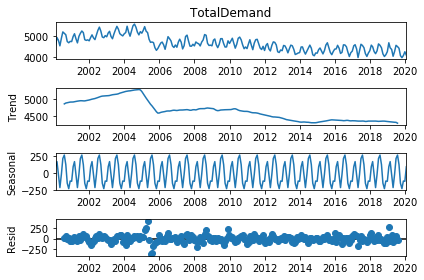

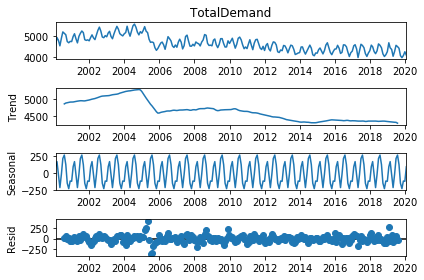

In [3]:
seasonal_decompose(data["TotalDemand"].resample("M").mean(), model="additive").plot()

## Removing trends
To ensure we make the right predictions, it is vital to separate the effect time has on energy usage.
This allows us to remove the effect of several variables which we are not aware of.
We can do this through diffing out data (subtracting $n$'th previous value from the current value)

*Note that the data must be sorted by region and date for this to work correctly. If the data is not sorted by region an error will be thrown, however, if not sorted by the date the diff function will spit out invalid data.*
*For clarity a test is below which prints True if the modifications have not changed index ordering (False otherwise).*
*Also, the data must be sorted purely by date and not by region after this has finished (like originally), as otherwise, the training and testing data will be skewed (i.e. the training/testing subsets may contain 100% of some states but 0% of others)!*

The data is differenciated by a value of 100 to remove the variations which happen over large timescales without sacrificing large amounts of data.
The specific number has been chosen through trial and error (through looking at the change in the graph's appearence).

In [4]:
# Sort dataframe by region so groupby's output can be combined and used for another column
data.sort_values(by=["Region", "Date"], inplace=True)
data["AdjustedDemand"] = data.groupby("Region")["TotalDemand"].diff(100)
all([region[1].sort_index().index.equals(region[1].index) for region in data.groupby("Region")])
data.sort_index(inplace=True)

True

When we graph the original total demand we find that it was not stationary, however when we overlay the new adjusted version it varies up and down across one straight line (implying that the trend has been removed).

Text(0, 0.5, 'Demand')

Text(0, 0.5, 'Demand')

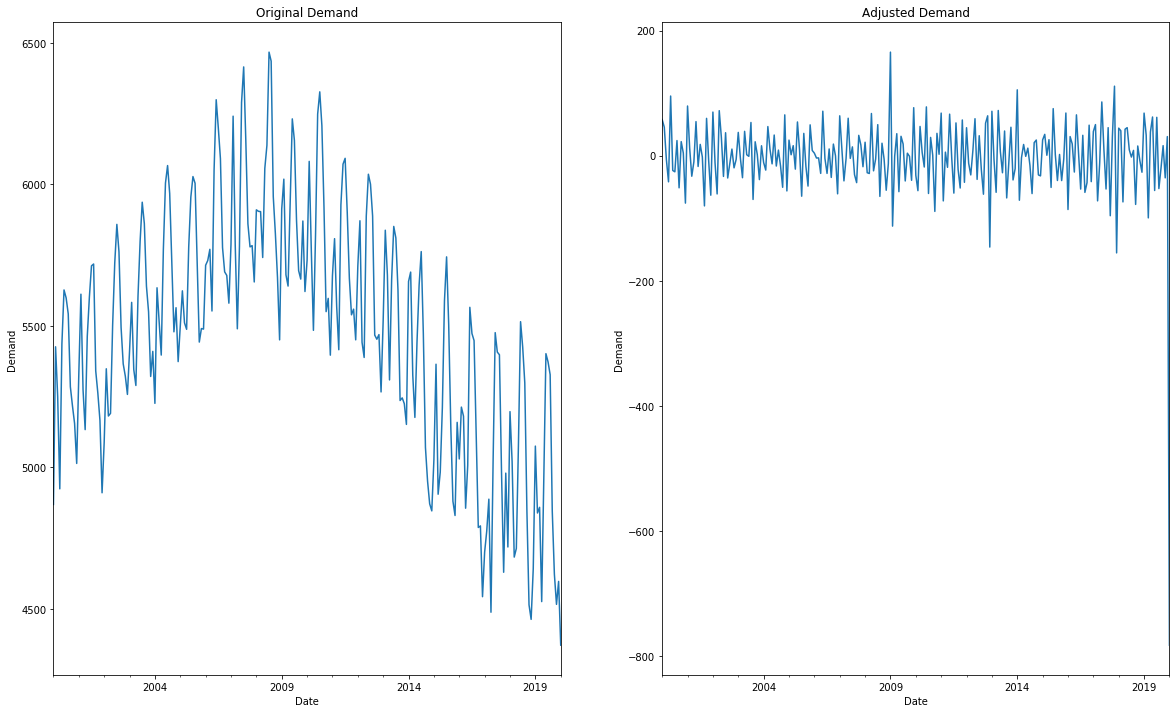

In [5]:
fix, axes = plt.subplots(ncols=2, figsize=(20, 12))
data.groupby("Region").get_group("VIC")["TotalDemand"].resample("M").mean().plot(ax=axes[0], title="Original Demand")
data.groupby("Region").get_group("VIC")["AdjustedDemand"].resample("M").mean().plot(ax=axes[1], title="Adjusted Demand")
axes[0].set_ylabel("Demand")
axes[1].set_ylabel("Demand")

We can also tell that the original distribution of values shifting up and down with time has been removed.
We know this as the number of potential energy demand values any temperature can take is greatly reduced.

The plots curvature is also greatly diminished indicating that there is now a greater relationship between temperature and energy demand.
We know this as the energy demand distribution for any year was previously represented on that graph as one slightly squashed arc/parabola.
For a different year, this parabola would likely be shifted by some unknown amount up or down.
After the differentiating though the distribution of points stays largely consistent with time.

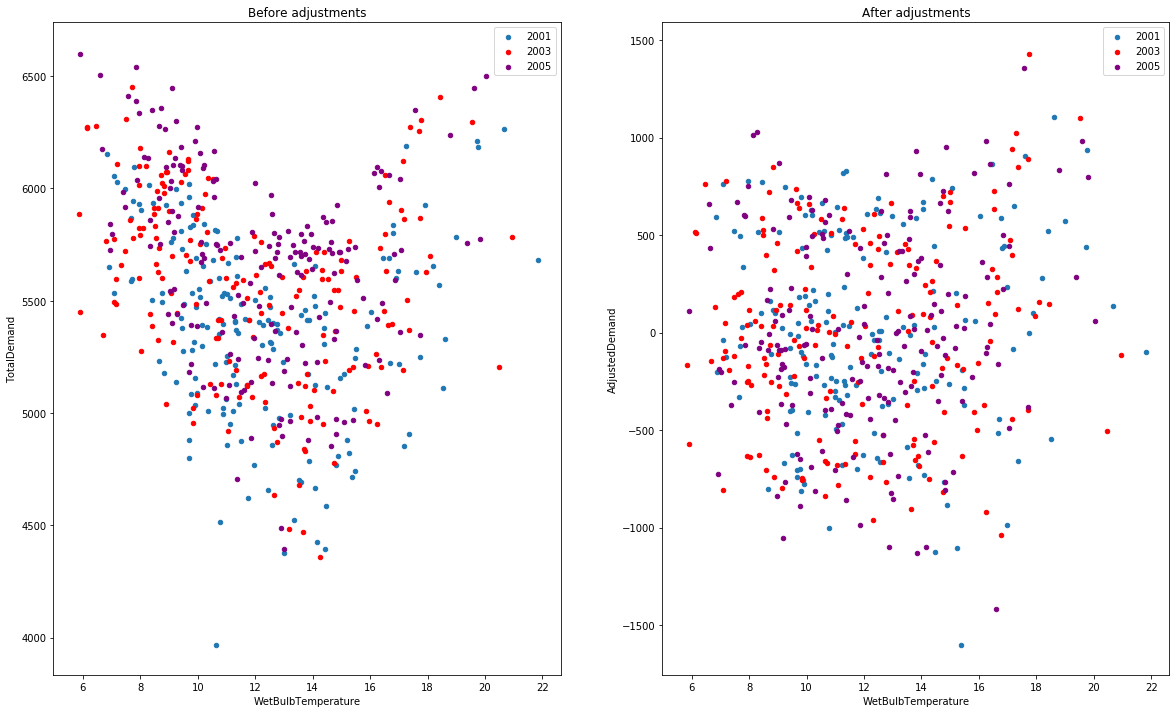

In [6]:
fix, axes = plt.subplots(ncols=2, figsize=(20, 12))
data["2001"].groupby("Region").get_group("VIC").resample("2D").mean().plot(x="WetBulbTemperature", y="TotalDemand", kind="scatter", ax=axes[0], title="Before adjustments")
data["2003"].groupby("Region").get_group("VIC").resample("2D").mean().plot(x="WetBulbTemperature", y="TotalDemand", kind="scatter", ax=axes[0], color="red")
data["2005"].groupby("Region").get_group("VIC").resample("2D").mean().plot(x="WetBulbTemperature", y="TotalDemand", kind="scatter", ax=axes[0], color="purple")
data["2001"].groupby("Region").get_group("VIC").resample("2D").mean().plot(x="WetBulbTemperature", y="AdjustedDemand", kind="scatter", ax=axes[1], title="After adjustments")
data["2003"].groupby("Region").get_group("VIC").resample("2D").mean().plot(x="WetBulbTemperature", y="AdjustedDemand", kind="scatter", ax=axes[1], color="red")
data["2005"].groupby("Region").get_group("VIC").resample("2D").mean().plot(x="WetBulbTemperature", y="AdjustedDemand", kind="scatter", ax=axes[1], color="purple")

axes[0].legend(["2001", "2003", "2005"])
axes[1].legend(["2001", "2003", "2005"])

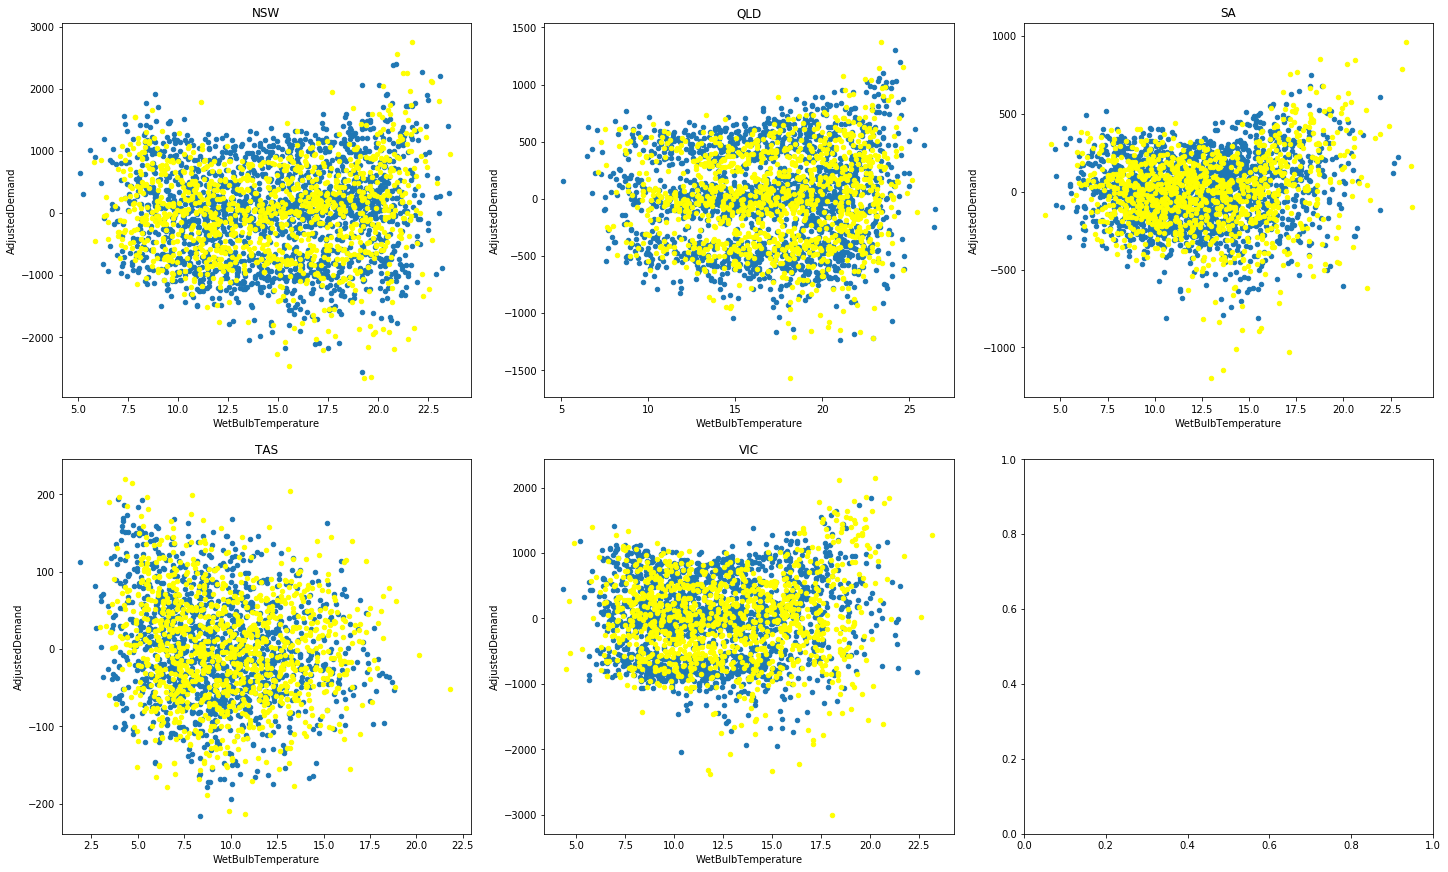

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), constrained_layout=True)
counter = [0, 0]
        
for region, region_data in data.groupby("Region"):
    region_data["2004":"2008"].resample("D").mean().plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y="AdjustedDemand", kind="scatter", title=region)
    region_data["2017":"2019"].resample("D").mean().plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y="AdjustedDemand", kind="scatter", color="yellow", title=region)
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1

## Divide up data
75% training data, 25% testing data.
Instead of making predictions every 30 minutes, we make 1 prediction each day (by resampling our data).
The primary reason for this is that the changes in temperature every half hour are either too small to accurately predict.
This decision implies that daily changes can not be predicted, however, it also means that the effect of outliers on the dataset is diminished (since there are ~48 predicts a day, so a few outliers will likely not affect the average).
*Note that resampling the data here is more complex than normal as it is essential to maintain the same date indices (like with the diff above)*.

Not all input features (i.e. columns) will be used to train the model.
This partially is because several present features contain the same information (i.e. the different measures of temperature are present), but mostly to prevent overfitting.
The effect of this decision is not demonstrated here for brevity, but rerunning the code below with the date as an integer and observing the nearly perfect performance on the training set outlines the inherent problem.

To overcome this issue without sacrificing the ability to predict seasonal changes, we use the information on days, weeks and months.
This is relatively safe, as daily, weekly and monthly shifts will either be present in most of the dataset or be nearly impossible to model.
The is true because of two assumptions:
* We are unable to control and observe model simplicity
* There is enough data, so anomalies/trends are relatively rare

Hyperparameters like max depth allow us to control the model simplicity, and the dataset spans a large timeframe so there are plenty of days, weeks and months (unlike with years).
Hence, the simple decision tree should struggle to pick up rare trends.
*Note that this is true for days, weeks and months but not years as we only have ~20 of the latter (in total), whilst days, weeks and months are decently plentiful!*

In [8]:
resampled_data = data.groupby("Region").resample("D").mean().reset_index("Region").sort_index()
train_data, test_data = train_test_split(resampled_data, shuffle=False)

input_columns = ["WetBulbTemperature", "Month", "Week", "Day"]
output_columns = ["AdjustedDemand"]

train_input_data, train_output_data = train_data[input_columns + ["Region"]], train_data[output_columns + ["Region"]]
test_input_data, test_output_data = test_data[input_columns + ["Region"]], test_data[output_columns + ["Region"]]

## Create and train a model
A grid search is used over 5 fold cross-validation to find the best possible hyperparameters.
We train one decision tree model per state instead of one model for all states to ensure their separate seasonal trends don't confuse the model.

Varying the model depth along with the minimum and maximum sample leaves changes the model complexity.
The fact that low values for maximum tree depth and maximum leaf nodes are chosen during cross-validation dictates that we have a simple model.
A small range of values are trialled out per hyperparameter, as adding more options tends to be extremely computationally costly (so those which performed best in initial experiments have been chosen).

Normally a random forest would be highly beneficial since bootstrapping (randomly sampling rows and columns/features) both reduces overfitting and the effect of particularly useless features.
However, here we have few unique features, so simpler decision trees are favourable over complex ensemble models.
Linear regression and polynomial regression have also been avoided as they had poor performance.

In [9]:
def get_best_model(test_input: pd.DataFrame, test_output: pd.DataFrame):
    paramaters = {"max_depth": [*range(1, 20), None], "min_samples_leaf": [2, 5, 10, 15], "max_leaf_nodes": [5, 10, 20, None]}
    regressor = DecisionTreeRegressor()
    grid = GridSearchCV(regressor, param_grid=paramaters, n_jobs=1)
    grid.fit(test_input, test_output.values.ravel())
    best_score, best_depth = grid.best_score_, grid.best_params_
    
    return grid, best_score, best_depth

In [10]:
def get_predictions(regressor, test_input, test_output, train_input=None, train_output=None):
    test_predictions = regressor.predict(test_input)
    test_results = pd.DataFrame(test_predictions, columns=output_columns, index=test_input.index)
    test_results = test_data[input_columns].join(test_results)
    
    if type(train_input) != None and type(train_output) != None:
        train_predictions = regressor.predict(train_input)
        train_results = pd.DataFrame(train_predictions, columns=output_columns, index=train_input.index)
        train_results = train_data[input_columns].join(train_results)
        
        return test_results, train_results
    return test_results

In [11]:
models, regressors = [], []

test_predictions, train_predictions = [], []

for region, dataframe in train_data.groupby("Region"):
    # Cross validate to find the best model
    model_input, model_output = dataframe.dropna()[input_columns], dataframe.dropna()[output_columns]
    grid, score, params = get_best_model(model_input, model_output)
    regressors.append(grid)
    models.append(regressors[-1].fit(model_input, model_output.values.ravel()))
    
    print(f"Best {region} model has a score of {score} and best params {params}")
    
    # Get the test data for this specific region
    test_input = test_data.groupby("Region").get_group(region)[input_columns].dropna()
    test_output = test_data.groupby("Region").get_group(region)[output_columns].dropna()
    
    # Generate predictions, obtain and log the final formatted data
    test_results, train_results = get_predictions(regressors[-1], test_input, test_output, model_input, model_output)
    test_predictions.append(test_results)
    train_predictions.append(train_results)

Best NSW model has a score of 0.7226597476143743 and best params {'max_depth': 11, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
Best QLD model has a score of 0.7534395869288315 and best params {'max_depth': 8, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
Best SA model has a score of 0.46757527137547833 and best params {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 10}
Best TAS model has a score of 0.40880950298523144 and best params {'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 15}
Best VIC model has a score of 0.722609047732475 and best params {'max_depth': 7, 'max_leaf_nodes': None, 'min_samples_leaf': 5}


## Visualise performance
To judge how well our model fairs, we create and analyse plots of energy and temperature.
We start by seeing the correlation of energy and temperature for each state (the predictions are blue, and the real values are red).
The data for this is from the test dataset, and the predictions (blue dots) seeming to form stripes suggests that the model has identified certain seasonal patterns in the data (this is why we have several lines instead of one).
*Note that these are nearly straight lines because of the previous adjustments which have removed the yearly trends which cause curvature in these plots.*
If the day, week and month of the year were not provided in the model, it would be forced to predict one straight line.

The large range of values (shown by the large area on each graph), shows that a number of factors are at play and that our current temperature data does not perfectly fit/explain the changes in energy demand.
*Note that other weather variables like precipitation have also been trialed with little success.*

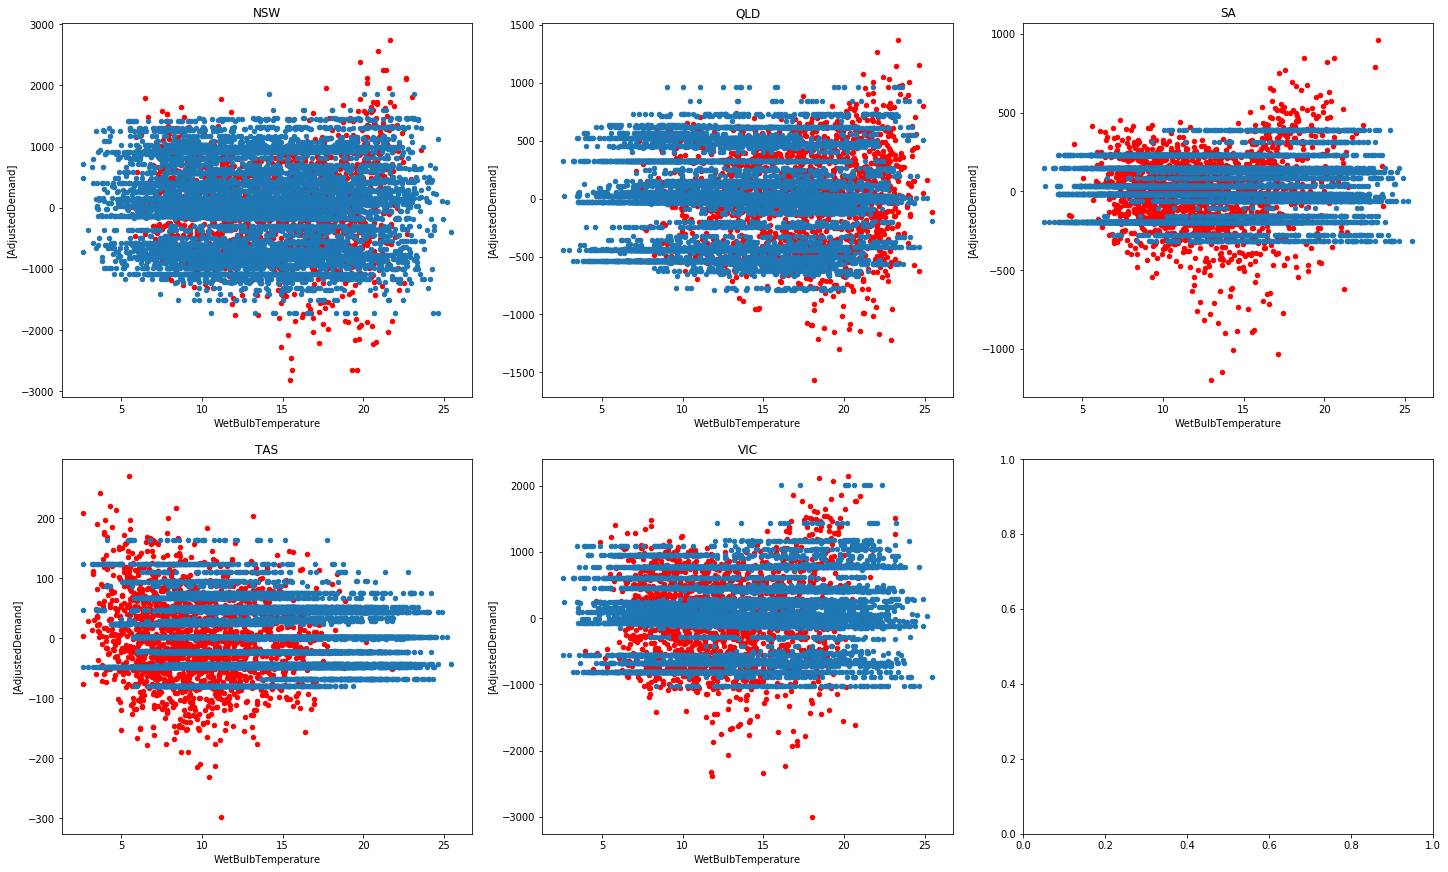

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), constrained_layout=True)
counter = [0, 0]
        
for region, region_data in test_data.groupby("Region"):
    region_data.plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y=output_columns, kind="scatter", color="red", title=region)
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1

counter = [0, 0]

for region_data in test_predictions:
    region_data.plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y=output_columns, kind="scatter")
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1

The training data vs training predictions, show us that our model has neither under nor overfit the data.
If it had underfitted the data, the model would not replicate the cyclic peaks and troughs.
If it had overfitted the data, the model would perfectly predict each point here, whilst struggling to accurately make predictions of the test set (shown further below).

The one important flaw here is that the model seems unable to predict yearly large increases in overall amounts of energy demand.
Although it currently might look like this indicates that our previous detrending of the dataset did not work, this is a seasonal trend which a, happens every year, and b does not affect the standard effect that temperature has on energy demand (which is why the largest part of the blue training data is covered by orange predictions).

We can also see that Tasmania is generally less predictable than other states.
It also has far less data.

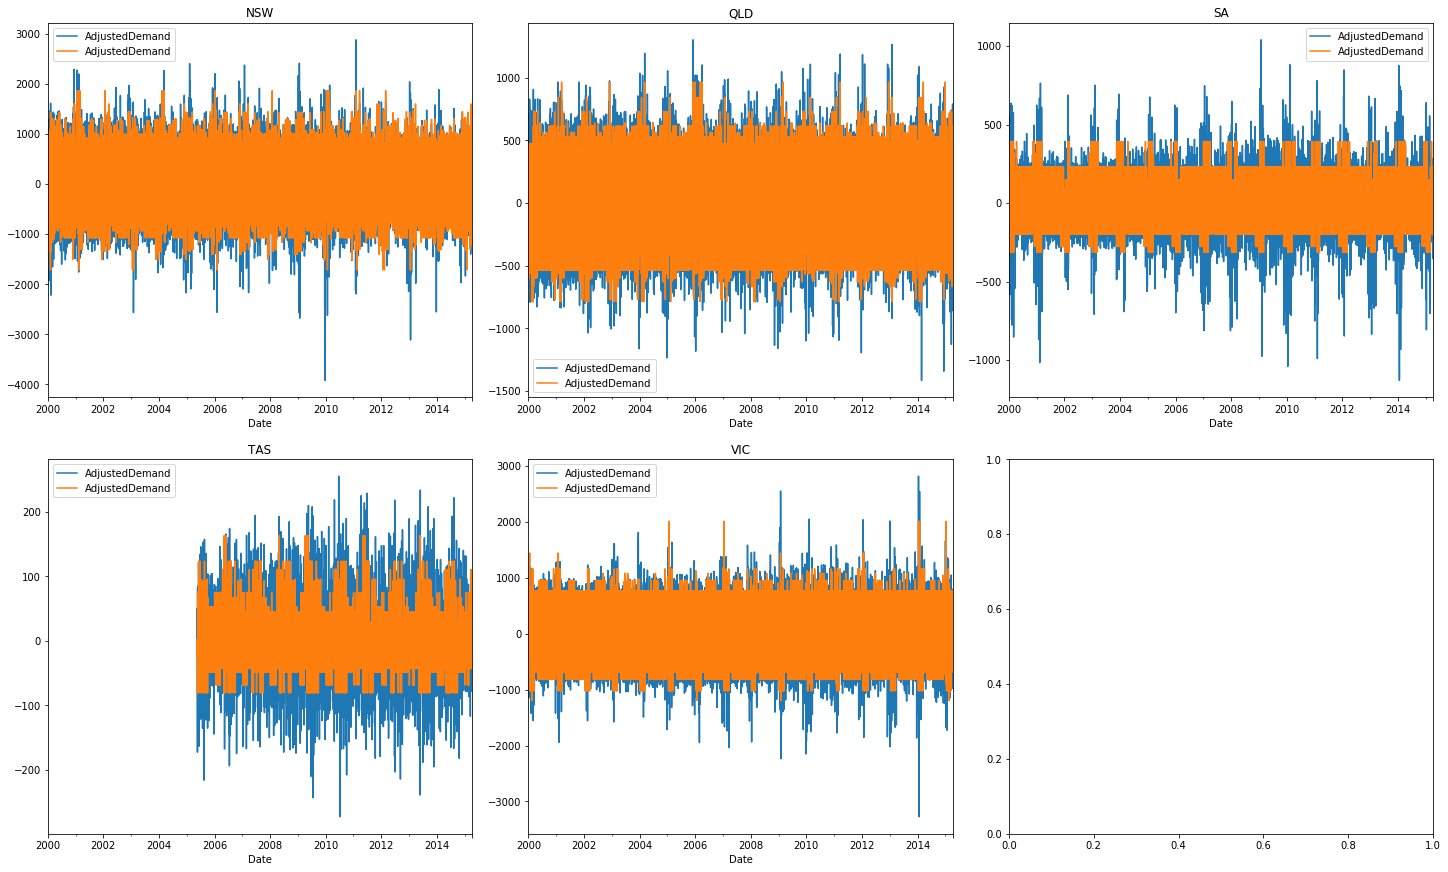

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), constrained_layout=True)
counter = [0, 0]
        
for region, region_data in train_data.groupby("Region"):
    region_data[output_columns].plot(ax=axes[counter[0], counter[1]], title=region)
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1

counter = [0, 0]

for region_data in train_predictions:
    region_data[output_columns].plot(ax=axes[counter[0], counter[1]])
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1

To actually judge the models performance, the below graphs all show the predictions on the test set.
The general daily peaks and troughs are once again all correctly predicted.

These graphs highlight the particular sections of increased energy demand (from the end of one year to the beginning of the next) which have not been modelled accurately.
The greateher energy usage is likely due to summer holidays.

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

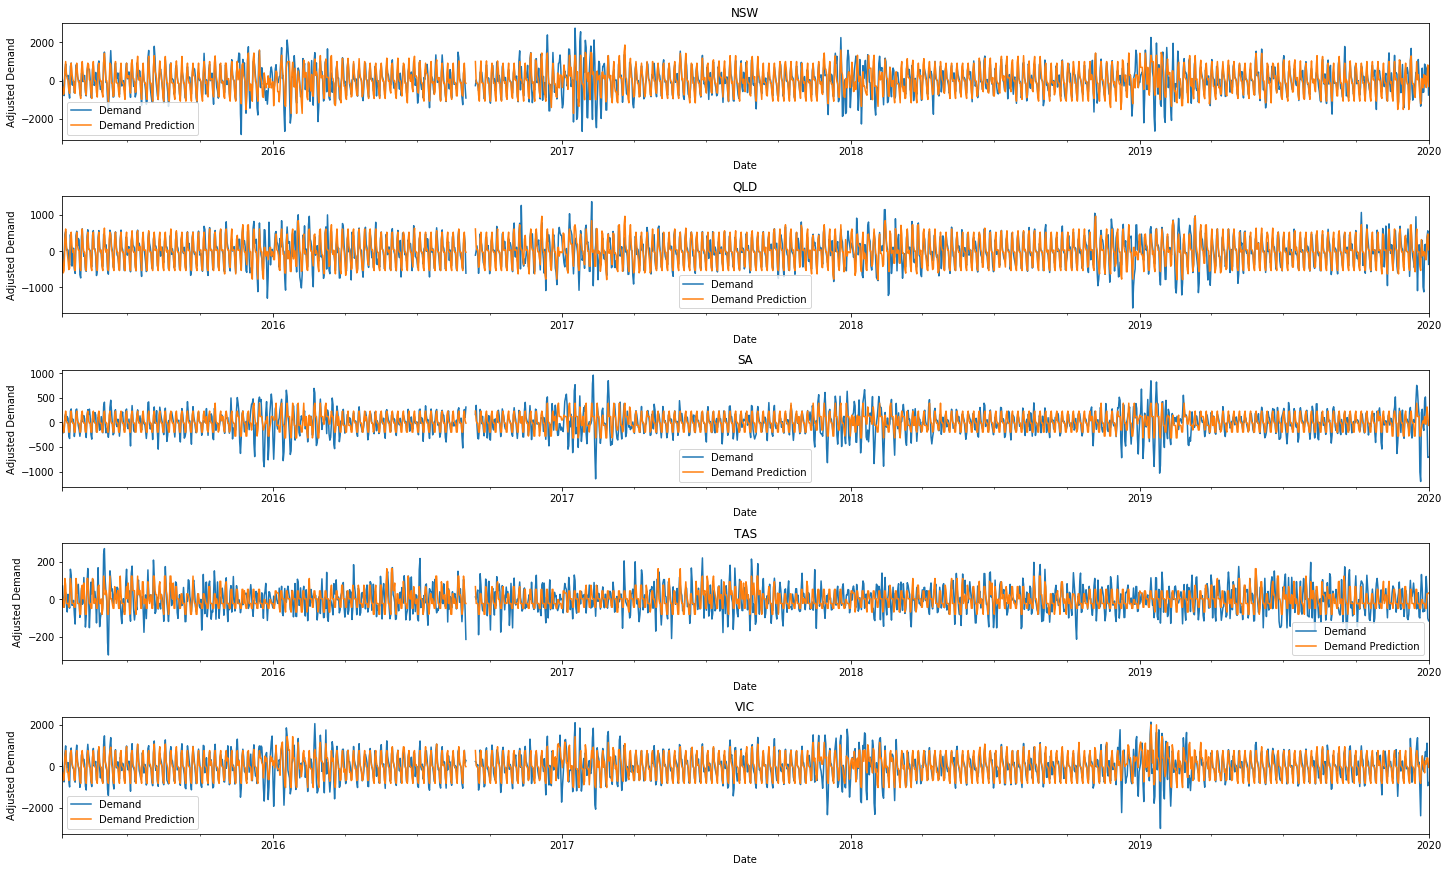

In [14]:
fig, axes = plt.subplots(nrows=5, figsize=(20, 12), constrained_layout=True)
        
for i, (region, region_data) in enumerate(test_data.groupby("Region")):
    region_data[output_columns].plot(ax=axes[i], title=region)
    test_predictions[i][output_columns].plot(ax=axes[i])
    axes[i].set_ylabel("Adjusted Demand")
    axes[i].legend(["Demand", "Demand Prediction"])

The energy demand of 2019 (by itself) shows the month to month predictions.
We can see that the model repeatedly predicts the temperature correct the majority of the time.

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

Text(0, 0.5, 'Adjusted Demand')

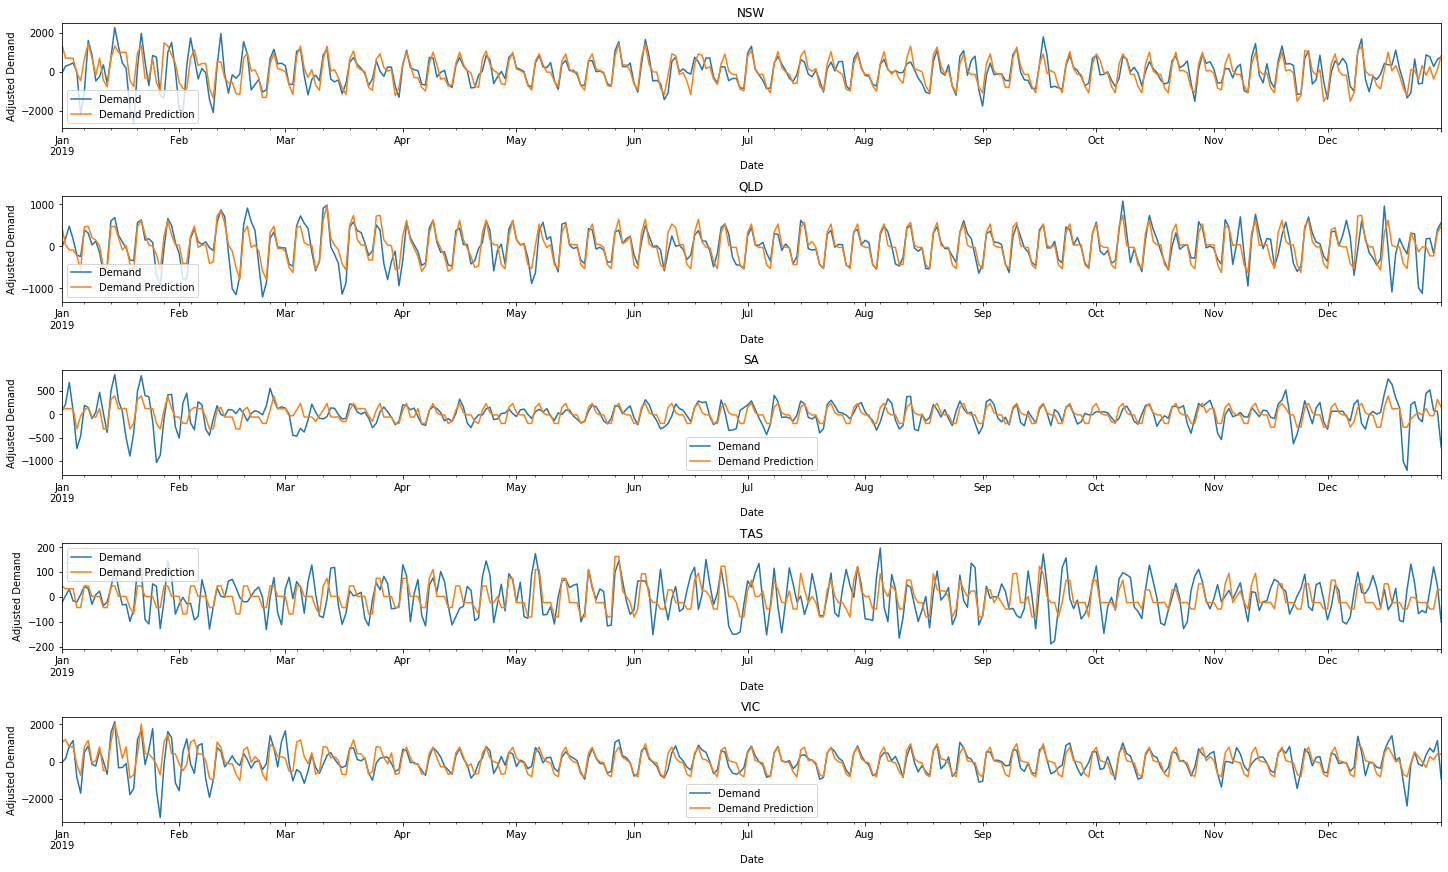

In [15]:
fig, axes = plt.subplots(nrows=5, figsize=(20, 12), constrained_layout=True)

for i, (region, region_data) in enumerate(test_data.groupby("Region")):
    region_data[output_columns]["2019"].plot(ax=axes[i], title=region)
    test_predictions[i][output_columns]["2019"].plot(ax=axes[i])
    axes[i].set_ylabel("Adjusted Demand")
    axes[i].legend(["Demand", "Demand Prediction"])

To explain this effect we can look at the differences in energy demand with time

Text(0, 0.5, 'Demand')

Text(0, 0.5, 'Demand')

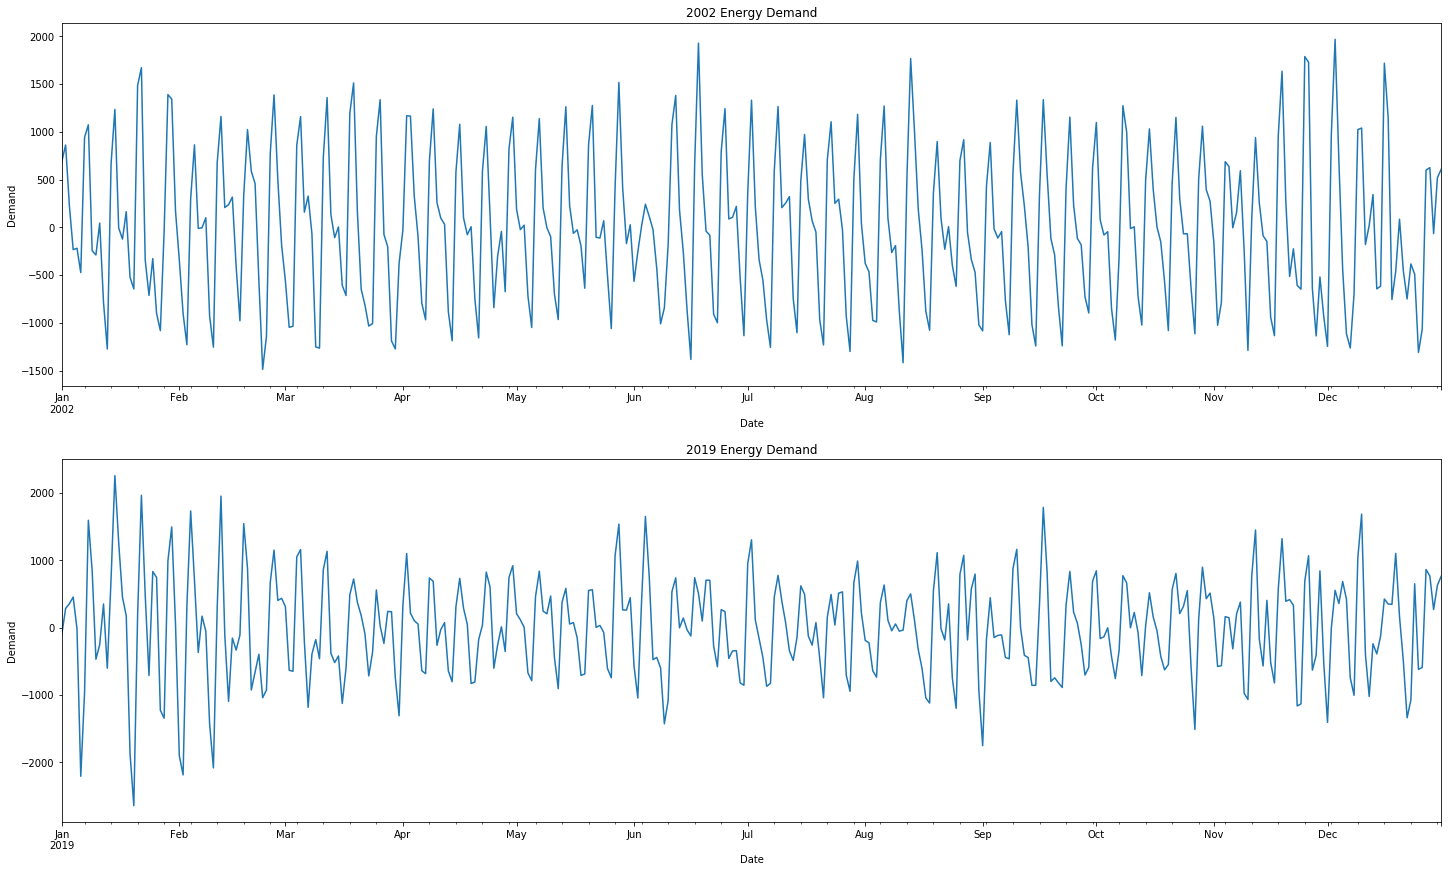

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(20, 12), constrained_layout=True)

train_data.groupby("Region").get_group("NSW")[output_columns]["2002"].plot(ax=axes[0], title="2002 Energy Demand", legend=None)
test_data.groupby("Region").get_group("NSW")[output_columns]["2019"].plot(ax=axes[1], title="2019 Energy Demand", legend=None)

axes[0].set_ylabel("Demand")
axes[1].set_ylabel("Demand")

## Conclusions
### Relationships
When the temperature is lower or higher, the demand is at its peak however the relative climate of each state has an impact on this as well.
Throughout a year, energy demand can peak on cold days when people use heaters to keep warm and on hot days when people use their air conditioners to keep cool.
Energy demand is higher during the day at 9 am and at its peak at 6 pm which is the time when people are most active within their homes.
Demand is also at its lowest at about 5 am when people are asleep.

### Ability to model data
From the graphs above we have seen that most states (apart from Tasmania) have largely predictable energy patterns throughout most of the year.
Our success with small decision trees (with information on temperature and seasons) show that there is a direct relationship between temperature, time (within a year) and energy demand.
However, attempts to model Australian energy usage through just temperature have been futile, suggesting that there are several other variables at play.
These likely include the increase in population per state, technological advancements, economic activity, summer holidays, travel and more.
This suggests that although we are able to predict energy demand in the short term (on a daily basis), we do not have the data to predict long-term future trends.

The graphs of the fit show that Tasmania (along with South Australia, but to a slightly lesser extent) was significantly harder to model than the other states (also shown in the cross-validation score of ~40%).
This could potentially be because there is less data for Tasmania than the other states.

### Recommendations
There are several improvements which could improve predictability.
The first would be to obtain data which describes large trends.
Although we were successfully able to separate yearly trends from seasonality, this is not quite as effective as being able (with data) to forecast these trends.
There are several features which would help, the first is population data.
The number of Australian's alive dictates how many people will be using power.
The second is technological advances which reduce or increase overall energy usage.
This would be difficult, and may not seem relevant, however over the years appliances like heaters, fridges and more have become far more efficient (meaning greater temperature may not result in as great an increase in energy as before).
Economic and cost-impacting variables also have a major impact on long-term trends, so GDP data/energy prices may also provide sizable improvements.

Data cleaning for the temperature was particularly difficult, and so there are several improvements which can be made (both to the cleaning procedure and the collection procedure).
The temperature data has large amounts of missing data, which limits the information which our model was capable of using.
A good portion of this would be largely irrelevant (as shown by the correlation table in the graphing section) and was easily overcome through using other columns of data, however, some of it would still likely be useful.
One particular example of this is completely missing quality estimates.
This would allow predicts of when measures were faulty and so not reliable (which may improve model performance).
With both the temperature and energy dataset being substantially large, a large number of CSV files is quite impractical.
Hence, a database or other efficient data structure would likely yield faster and less error-prone data importing (whilst additionally removing problems like inconsistant formatting of data).